Kaggle link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


# Sourcing the Data

In [ ]:
od.download(
    "https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview")
housing_df = pd.read_csv('/content/house-prices-advanced-regression-techniques/train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: samhitha05
Your Kaggle Key: ··········


100%|██████████| 199k/199k [00:00<00:00, 544kB/s]


Extracting archive ./house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques.zip to ./house-prices-advanced-regression-techniques


After downloading the dataset from kaggle, we observe that the train and test datasets have been split in half. The test dataset does not have the finaly y variable. So we have decided to proceed with only using the train dataset, so that we can calculate final test scores.

# Data Preprocessing

In [ ]:
categorical_columns = housing_df.select_dtypes(include='object').columns.to_list()
for category in categorical_columns:
  print(housing_df[category].value_counts(dropna=False))

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale  

Dropping Columns that have missing values above 50 percent.

In [ ]:
df = housing_df.drop(['Fence', 'PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=False)

Replacing nan with a column value in Garage, Fireplace and Bsmt based columns.

In [ ]:
df['GarageCond'] = df['GarageCond'].fillna('NoGarage')
df['GarageFinish'] = df['GarageFinish'].fillna('NoGarage')
df['GarageQual'] = df['GarageQual'].fillna('NoGarage')
df['GarageType'] = df['GarageType'].fillna('NoGarage')
df['GarageCond'] = df['GarageCond'].fillna('NoGarage')

df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')

df.loc[:, 'BsmtQual'] = df['BsmtQual'].fillna('NoBasement')
df.loc[:, 'BsmtCond'] = df['BsmtCond'].fillna('NoBasement')
df.loc[:, 'BsmtExposure'] = df['BsmtExposure'].fillna('NoBasement')
df.loc[:, 'BsmtFinType1'] = df['BsmtFinType1'].fillna('NoBasement')
df.loc[:, 'BsmtFinType2'] = df['BsmtFinType2'].fillna('NoBasement')

# Dropping GarageYrBlt since it is same as the YearBuilt.
df = df.drop(['GarageYrBlt'], axis=1)

# Notice BsmtExposure has 38 NaN, while BsmtFinType1 has 37 NaN, so remove this row
df = df[~(df['BsmtExposure'].isna() & df['BsmtFinType1'].notna())]

In [ ]:
#check numerical columns for nan values
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

nan_counts = numerical_cols.isna().sum()
nan_counts[nan_counts > 0]

,0
LotFrontage,259
MasVnrArea,8


In [ ]:
# drop rows with NaN in MasVnrArea and Electrical
df = df.dropna(subset=['MasVnrArea', 'Electrical'])

# fill LotFrontage column nan values with 0 indicating no lot frontage space
df['LotFrontage'].fillna(0, inplace=True)

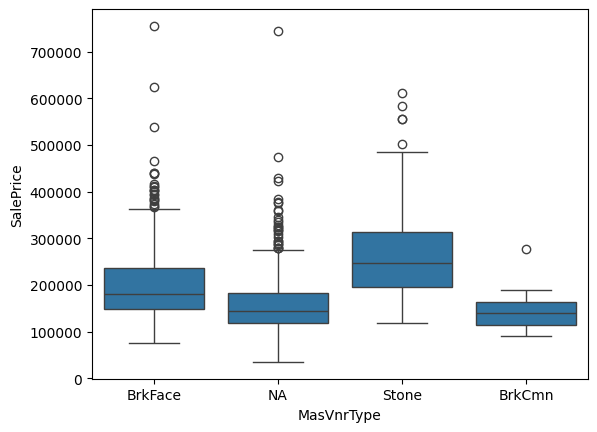

In [ ]:
df['MasVnrType'].fillna('NA', inplace=True)

# Plot using seaborn, including the 'missing' column
sns.boxplot(x=df['MasVnrType'], y =df['SalePrice'], data=df)
plt.show()

In [ ]:
# dropping MasVnrType column as 50% of the were missing, and no strong
# correlation was seen between the NA values and target variable

df = df.drop(['MasVnrType'], axis=1)

In [ ]:
# nan_counts = df.select_dtypes(include='object').isna().sum()
# print(nan_counts[nan_counts > 0])

# print('Numerical')
# nan_counts = df.select_dtypes(include=['float64', 'int64']).isna().sum()
# print(nan_counts[nan_counts > 0])

# Implementation

## Train - Test Split

In [ ]:
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)
print(df.shape)

(1451, 75)


In [ ]:
# train/test split (80/20)
from sklearn.model_selection import train_test_split
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Categorical Encoding

In [ ]:
# get all categorical feature column names
cat_feat = X_dev.select_dtypes(include=['object']).columns

In [ ]:
# One-hot encode categorical features, since RandomForestRegressor
# in sklearn can not handle categorical features
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

process_ohe = make_column_transformer((OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_feat), remainder='passthrough')
X_dev = process_ohe.fit_transform(X_dev)
X_test = process_ohe.transform(X_test)

## Random Forest Regressor

In [ ]:
# find best Random Forest params using Grid Search and OOB score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
n_estimators = [20, 30, 40, 50, 100]
max_depths = [12, 15, 20, 30, 50]
max_features = [0.3, 0.35, 0.4, 0.45]
max_score = -1
max_params = None
for est in n_estimators:
    for depth in max_depths:
      for feat in max_features:
          rf = RandomForestRegressor(random_state=0, oob_score=True, n_estimators=est, max_depth=depth, max_features=feat)
          rf.fit(X_dev, y_dev)
          oob_sc = rf.oob_score_
          if oob_sc > max_score:
              max_score = oob_sc
              max_params = est, depth, feat
print("Best n_estimator:", max_params[0])
print("Best max_depth:", max_params[1])
print("Best max_feature:", max_params[2])

Best n_estimator: 30
Best max_depth: 30
Best max_feature: 0.3


In [ ]:
# train Random Forest with best params
random_forest_best = RandomForestRegressor(random_state=0, n_estimators=max_params[0], max_depth=max_params[1], max_features=max_params[2])
random_forest_best.fit(X_dev, y_dev)

print("R2 Score Development: ", random_forest_best.score(X_dev, y_dev))
print("R2 Score Test: ", random_forest_best.score(X_test, y_test))

R2 Score Development:  0.9778006655388578
R2 Score Test:  0.9201573626821968


In [ ]:
# get non-categorical features
numeric_feat = df.select_dtypes(exclude=['object', 'category']).columns

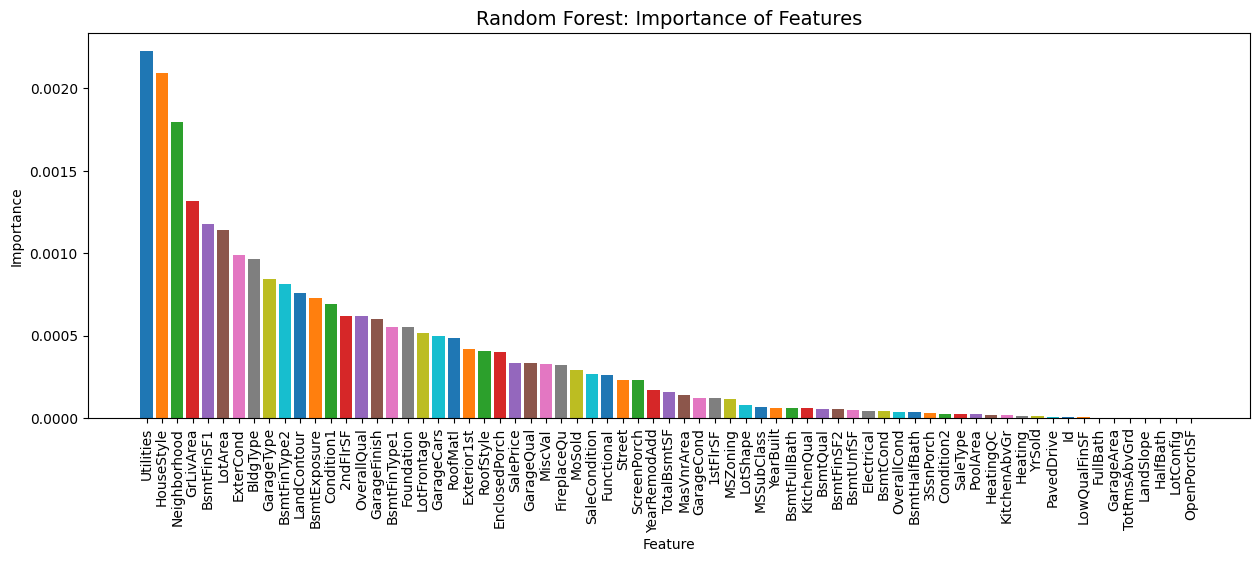

In [ ]:
# plot feature importances for Random Forest

def feature_importance_plot(features, title):
  all_feats = cat_feat.tolist() + numeric_feat.tolist()
  combined_forest = zip(all_feats, features)
  feats, imps = zip(*(sorted(list(filter(lambda x:x[1] !=0, combined_forest)), key=lambda x: x[1], reverse=True)))
  forest_importance_df = pd.DataFrame({'feat': feats,'imp': imps})
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  plt.figure(figsize=(15, 5))
  plt.bar(forest_importance_df['feat'], forest_importance_df['imp'], color=colors[:len(feats)])
  plt.xticks(rotation=90)
  plt.ylabel("Importance")
  plt.xlabel("Feature")
  plt.title(title, fontsize=14)
  plt.show()

forest_importances = random_forest_best.feature_importances_
feature_importance_plot(forest_importances, "Random Forest: Importance of Features")


Top 5 features for Random Forest are:
1. Utilities <br>
2. HouseStyle <br>
3. Neighborhood <br>
1. GrLivArea <br>
2. BsmtFinSF1 <br>

These predictions intuitively make sense.

## XGBRegressor

In [ ]:
from xgboost import XGBRegressor

max_depth = [3, 4, 5, 6]
min_child_weight = [4, 5, 6, 8]
colsample_bytree = [0.1, 0.5, 0.8, 1]
max_score_xgb = -1
best_params = None

for min_child in min_child_weight:
    for depth in max_depth:
      for sample in colsample_bytree:
        print(min_child, depth, sample)
        xgb = XGBRegressor(min_child_weight=min_child, colsample_bytree=sample, max_depth=depth)
        xgb.fit(X_dev, y_dev)
        score = xgb.score(X_test, y_test)
        if score > max_score_xgb:
            max_score_xgb = score
            best_params = min_child, depth, sample

print("Best min child weight:", best_params[0])
print("Best max depth:", best_params[1])
print("Best column sample by tree:", best_params[2])

4 3 0.1
4 3 0.5
4 3 0.8
4 3 1
4 4 0.1
4 4 0.5
4 4 0.8
4 4 1
4 5 0.1
4 5 0.5
4 5 0.8
4 5 1
4 6 0.1
4 6 0.5
4 6 0.8
4 6 1
5 3 0.1
5 3 0.5
5 3 0.8
5 3 1
5 4 0.1
5 4 0.5
5 4 0.8
5 4 1
5 5 0.1
5 5 0.5
5 5 0.8
5 5 1
5 6 0.1
5 6 0.5
5 6 0.8
5 6 1
6 3 0.1
6 3 0.5
6 3 0.8
6 3 1
6 4 0.1
6 4 0.5
6 4 0.8
6 4 1
6 5 0.1
6 5 0.5
6 5 0.8
6 5 1
6 6 0.1
6 6 0.5
6 6 0.8
6 6 1
8 3 0.1
8 3 0.5
8 3 0.8
8 3 1
8 4 0.1
8 4 0.5
8 4 0.8
8 4 1
8 5 0.1
8 5 0.5
8 5 0.8
8 5 1
8 6 0.1
8 6 0.5
8 6 0.8
8 6 1
Best min child weight: 5
Best max depth: 5
Best column sample by tree: 1


In [ ]:
xgb_best = XGBRegressor(min_child_weight=best_params[0], colsample_bytree=best_params[2], max_depth=best_params[1])
xgb_best.fit(X_dev, y_dev)

print("XGB Score Development: ", xgb_best.score(X_dev, y_dev))
print("XGB Score Test: ", max_score_xgb)

XGB Score Development:  0.9982163310050964
XGB Score Test:  0.9200243949890137


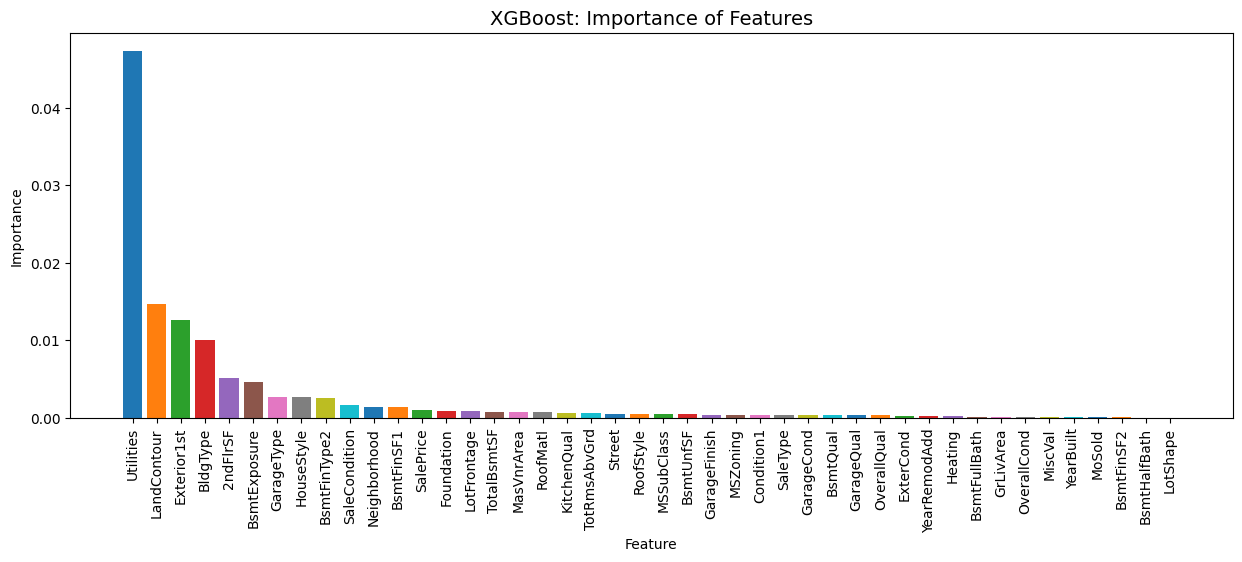

In [ ]:
xgb_importances = xgb_best.feature_importances_
feature_importance_plot(xgb_importances, "XGBoost: Importance of Features")